In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime

## Things we want to "demo" in this handcrafted example files

* Profiles of differing number of "levels" (e.g. less than 36 bottles, ctds of different depth)
* variables that need more information (e.g. optical things which need wavelengths, pathlengths, angles, etc..)
* ACDD attrs at the variable level
* Combined ACDD variable level vars into global level (for compliance with actual ACDD-1.3)
* quality flags (following CF)
* compression? (zlib)
* Use of cchdo specific attrs
* "Complete" capture of "Bob's Header" in standardized attrs

Chosen cruise: 2016 I08S (33RR20160208)

In [3]:
with open("33RR20160208_hy1.csv", 'r', encoding='utf8') as f:
    bottle_data = f.read()
comments = [line for line in bottle_data.splitlines() if line.startswith("#")]

def date_parser(dt):
    if dt == "nan nan":
        return None
    return pd.datetime.strptime(dt, "%Y%m%d        %H%M")

data = pd.read_csv("33RR20160208_hy1.csv", skiprows=[0,1], comment='#', header=[0], parse_dates=[["DATE", "TIME"]], date_parser=date_parser, na_values=[-999])
# drop the "units" and "END_DATA" for ease of working with
data = data.drop(0).drop(data.index[-1])

In [4]:
data["OXYGEN"] = data["OXYGEN"].astype(float)
data.loc[data["OXYGEN"]==-999, 'OXYGEN'] = np.nan

In [5]:
#non fancy select some stations
stn1 = data[:20]
stn2 = data[20:42]
stn6 = data[134:170]

stations = [stn1, stn2, stn6]

In [6]:
#lets grab some easy 1d vars
expocode = xr.DataArray(
    data=[s['EXPOCODE'].iloc[0] for s in stations],
    dims=['N_PROF'],
    attrs={
        "whp_name": "EXPOCODE"
    }
)
stnnbr = xr.DataArray(
    data=[str(int(s['STNNBR'].iloc[0])) for s in stations],
    dims=['N_PROF'],
    attrs={
        "whp_name": "STNNBR"
    }
)
castno = xr.DataArray(
    data=[int(s['CASTNO'].iloc[0]) for s in stations],
    dims=['N_PROF'],
    attrs={
        "whp_name": "CASTNO"
    }
)
woce = xr.DataArray(
    data=[str(s['SECT_ID'].str.strip().iloc[0]) for s in stations],
    dims=['N_PROF'],
    attrs={
        "whp_name": "SECT_ID"
    }
)
lat = xr.DataArray(
    data=[(s['LATITUDE'].iloc[0]) for s in stations],
    dims=['N_PROF'],
    attrs={
        "standard_name": "latitude",
        "units": "degrees_north",
        "axis": "Y",
    }
)
lon = xr.DataArray(
    data=[(s['LONGITUDE'].iloc[0]) for s in stations],
    dims=['N_PROF'],
    attrs={
        "standard_name": "latitude",
        "units": "degrees_east",
        "axis": "X",
    }
)
date = xr.DataArray(
    data=[(s['DATE_TIME'].iloc[0]) for s in stations],
    dims=['N_PROF'],
    attrs={
        "standard_name": "time",
        "axis": "T",
    }
)

In [7]:
# Lets try a 2d thing
ctdprs = xr.DataArray(
    data=pd.DataFrame([s['CTDPRS'].astype(float).values[::-1] for s in stations]).values,
    dims=['N_PROF', "N_LEVEL"],
    attrs={
        "standard_name": "sea_water_pressure",
        "units": "dbar",
        "axis": "Z",
        "positive": "down",
        "whp_name": "CTDPRS",
        "whp_unit": "DBAR"
    }
)
oxygen = xr.DataArray(
    data=pd.DataFrame([s['OXYGEN'].astype(float).values[::-1] for s in stations]).values,
    dims=['N_PROF', "N_LEVEL"],
    attrs={
        "standard_name": "moles_of_oxygen_per_unit_mass_in_sea_water",
        "units": "umol kg-1",
        "whp_name": "OXYGEN",
        "whp_unit": "UMOL/KG",
        "creator_name": "Swift, James",
        "creator_email": "jswift@ucsd.edu",
        "creator_institution": "Scripps Institution of Oceanography",
        "geospatial_bounds": "MULTIPOINT ((78.3815 -66.6027), (78.2986 -66.4997), (78.0102 -66.15))",
        "geospatial_lat_min": -66.6027,
        "geospatial_lat_max": -66.15,
        "geospatial_lon_min": 78.0102,
        "geospatial_lon_max": 78.3815,
        "creator_type": "person",
        "program": "GO-SHIP",
        "contributor_name": ["Barna, Andrew","Becker, Susan"],
        "contributor_role": ["Shipboard Tech","Shipboard Tech"],
        "geospatial_lat_units": "degrees_north",
        "geospatial_lon_units": "degrees_east",
        "date_issued": "2016-04-12",
    },
    coords={"pressure": ctdprs, "latitude": lat, "longitude": lon, "date": date}
)
oxygen_qf = xr.DataArray(
    data=pd.DataFrame([s['OXYGEN_FLAG_W'].astype(int).values[::-1] for s in stations]).values,
    dims=['N_PROF', "N_LEVEL"],
    attrs={
        "standard_name": "moles_of_oxygen_per_unit_mass_in_sea_water status_flag",
        "whp_name": "OXYGEN_FLAG_W",
        "flag_values": "1b 2b 3b 4b 5b 6b 7b 8b 9b",
        "flag_meanings": "def1 def2 def3 def4 def5 def6 def7 def8 def9",
    },
    encoding={
        "dtype": np.int8,
        "_FillValue": 9,
    }
)

In [8]:
# pick another param, remove a station for demo purposes
ph_data = pd.DataFrame([s['PH_TOT'].astype(float).values[::-1] for s in stations]).values
ph_data[0] = np.nan
ph_qf_data = pd.DataFrame([s['PH_TOT_FLAG_W'].astype(int).values[::-1] for s in stations]).values
ph_qf_data[0] = np.nan
ph = xr.DataArray(
    data=ph_data,
    dims=['N_PROF', "N_LEVEL"],
    attrs={
        "standard_name": "sea_water_ph_reported_on_total_scale",
        "units": "1",
        "whp_name": "PH_TOT",
        "creator_name": "Dickson, Andrew",
        "creator_email": "adickson@ucsd.edu",
        "creator_institution": "Scripps Institution of Oceanography",
        "geospatial_bounds": "MULTIPOINT ((78.2986 -66.4997), (78.0102 -66.15))",
        "geospatial_lat_min":-66.4997,
        "geospatial_lat_max": -66.15,
        "geospatial_lon_min": 78.0102,
        "geospatial_lon_max": 78.2986,
        "creator_type": "person",
        "program": "GO-SHIP",
        "contributor_name": ["Belmonte, Manuel","Cervantes, David"],
        "contributor_role": ["Shipboard Tech","Shipboard Tech"],
        "geospatial_lat_units": "degrees_north",
        "geospatial_lon_units": "degrees_east",
        "date_issued": "2016-04-12",
    },
    coords={"pressure": ctdprs, "latitude": lat, "longitude": lon, "date": date}
)
ph_qf = xr.DataArray(
    data=ph_qf_data,
    dims=['N_PROF', "N_LEVEL"],
    attrs={
        "standard_name": "sea_water_ph_reported_on_total_scale status_flag",
        "whp_name": "PH_TOT_FLAG_W",
        "flag_values": "1b 2b 3b 4b 5b 6b 7b 8b 9b",
        "flag_meanings": "def1 def2 def3 def4 def5 def6 def7 def8 def9",
    },
    encoding={
        "dtype": np.int8,
        "_FillValue": 9,
    }
)

In [9]:
# some "fake CDOM data"
fake = pd.read_csv("cdom.csv", header=None, na_values=[-999, 9]).values
wavelength = xr.DataArray(
    data=[325, 370, 443],
    dims=["N_WAVELENGTH0"],
    attrs={
        "standard_name": "radiation_wavelength",
        "units": "nm"
    }
)
cdom_data = np.empty((3,36,3))
cdom_data.fill(np.nan)
cdom_data[2,:,0] = fake[:,0]
cdom_data[2,:,1] = fake[:,2]
cdom_data[2,:,2] = fake[:,4]
cdom_qc = np.empty((3,36,3))
cdom_qc.fill(np.nan)
cdom_qc[2,:,0] = fake[:,1]
cdom_qc[2,:,1] = fake[:,3]
cdom_qc[2,:,2] = fake[:,5]
cdom = xr.DataArray(
    data=cdom_data,
    dims=['N_PROF', "N_LEVEL", "N_WAVELENGTH0"],
    coords={"pressure": ctdprs, "latitude": lat, "longitude": lon, "date": date, "wavelength0":wavelength},
    attrs={
        "standard_name": "volume_beam_attenuation_coefficient_of_radiative_flux_in_sea_water_due_to_colored_dissolved_organic_matter", #this name isn't real
        "units": "m-1",
        "whp_name": "CDOM{wavelength0}",
        "whp_unit": "1/M",
        "creator_name": "Kosei Sasaoka",
        "creator_email": "sasaoka@jamstec.go.jp",
        "creator_institution": "Japan Agency for Marine-Earth Science and Technology",
        "creator_type": "person",
        "geospatial_bounds": "MULTIPOINT ((78.0102 -66.15))",
        "geospatial_lat_min":-66.15,
        "geospatial_lat_max": -66.15,
        "geospatial_lon_min": 78.0102,
        "geospatial_lon_max": 78.0102,
        "program": "GO-SHIP",
        "geospatial_lat_units": "degrees_north",
        "geospatial_lon_units": "degrees_east",
        "date_issued": "2016-04-12",
    }
)
cdom_qf = xr.DataArray(
    data=cdom_qc,
    dims=['N_PROF', "N_LEVEL", "N_WAVELENGTH0"],
    coords={"pressure": ctdprs, "latitude": lat, "longitude": lon, "date": date, "wavelength0":wavelength}, 
    attrs={
        "standard_name": "volume_beam_attenuation_coefficient_of_radiative_flux_in_sea_water_due_to_colored_dissolved_organic_matter status_flag",
        "whp_name": "CDOM{wavelength0}_FLAG_W",
        "flag_values": "1b 2b 3b 4b 5b 6b 7b 8b 9b",
        "flag_meanings": "def1 def2 def3 def4 def5 def6 def7 def8 def9",
    },
    encoding={
        "dtype": np.int8,
        "_FillValue": 9,
    }
)

In [16]:
example = xr.Dataset(data_vars={
    "var0": oxygen, 
    "var1": oxygen_qf, 
    "var2": ph, 
    "var3": ph_qf, 
    "var4": cdom,
    "var5": cdom_qf,
    },
    coords={
        "wavelength0": wavelength,
        "var6": expocode,
        "var7": stnnbr, 
        "var8": castno, 
        "var9": woce,
    },
    attrs={
        "Conventions": "CF-1.7 ACDD-1.3 CCHDO-0.0",
        "title": "CCHDO netCDF example file",
        "warning": "The data are not real, this is only a file to demo features of the work in progress"
    }
)

In [17]:
example.var0.attrs["ancillary_variables"] = "var1"
example.var2.attrs["ancillary_variables"] = "var3"
example.var4.attrs["ancillary_variables"] = "var5"

In [18]:
example.to_netcdf("example_cchdo.nc")

In [19]:
example.attrs

OrderedDict([('Conventions', 'CF-1.7 ACDD-1.3 CCHDO-0.0'),
             ('title', 'CCHDO netCDF example file'),
             ('warning',
              'The data are not real, this is only a file to demo features of the work in progress')])

In [29]:
from collections import defaultdict

combining = (
    "creator_name",
    "creator_email",
    "creator_institution",
    "geospatial_bounds",
    "geospatial_lat_min",
    "geospatial_lat_max",
    "geospatial_lon_min",
    "geospatial_lon_max",
    "creator_type",
    "program",
    "contributor_name",
    "contributor_role",
    "geospatial_lat_units",
    "geospatial_lon_units",
    "date_issued",
)

def combine_creators(attrd):
    combined = {
        "creator_name":[],
        "creator_email":[],
        "creator_institution":[]
    }
                
    for key in combined:
        for _, value in attrd[key].items():
            if type(value) == list:
                combined[key].extend(value)
            else:
                combined[key].append(value)
    return combined

attrs = defaultdict(dict)
for var in example:
    for key, value in example[var].attrs.items():
        attrs[key][var] = value
        
combine_creators(attrs)

{'creator_name': ['Swift, James', 'Dickson, Andrew', 'Kosei Sasaoka'],
 'creator_email': ['jswift@ucsd.edu',
  'adickson@ucsd.edu',
  'sasaoka@jamstec.go.jp'],
 'creator_institution': ['Scripps Institution of Oceanography',
  'Scripps Institution of Oceanography',
  'Japan Agency for Marine-Earth Science and Technology']}

In [40]:
example.loc[{"var6":"33RR20160208"}]

ValueError: dimensions or multi-index levels ['var6'] do not exist

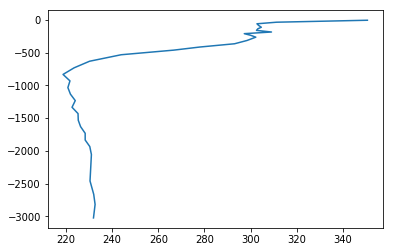

In [79]:
plot(example.where(example.var7=="6", drop=True).var0[0], -example.where(example.var7=="6", drop=True).var0.pressure[0])

In [72]:
from matplotlib.pylab import plot

In [50]:
example.var7

<xarray.DataArray 'var7' (N_PROF: 3)>
array(['1', '2', '6'], dtype='<U1')
Coordinates:
    latitude   (N_PROF) float64 -66.6 -66.5 -66.15
    longitude  (N_PROF) float64 78.38 78.3 78.01
    date       (N_PROF) datetime64[ns] 2016-02-19T05:57:00 ... 2016-02-20T03:46:00
    var6       (N_PROF) <U12 '33RR20160208' '33RR20160208' '33RR20160208'
    var7       (N_PROF) <U1 '1' '2' '6'
    var8       (N_PROF) int64 1 3 1
    var9       (N_PROF) <U4 'I08S' 'I08S' 'I08S'
Dimensions without coordinates: N_PROF
Attributes:
    whp_name:  STNNBR